## FTRL (Follow The Regularized Leader)
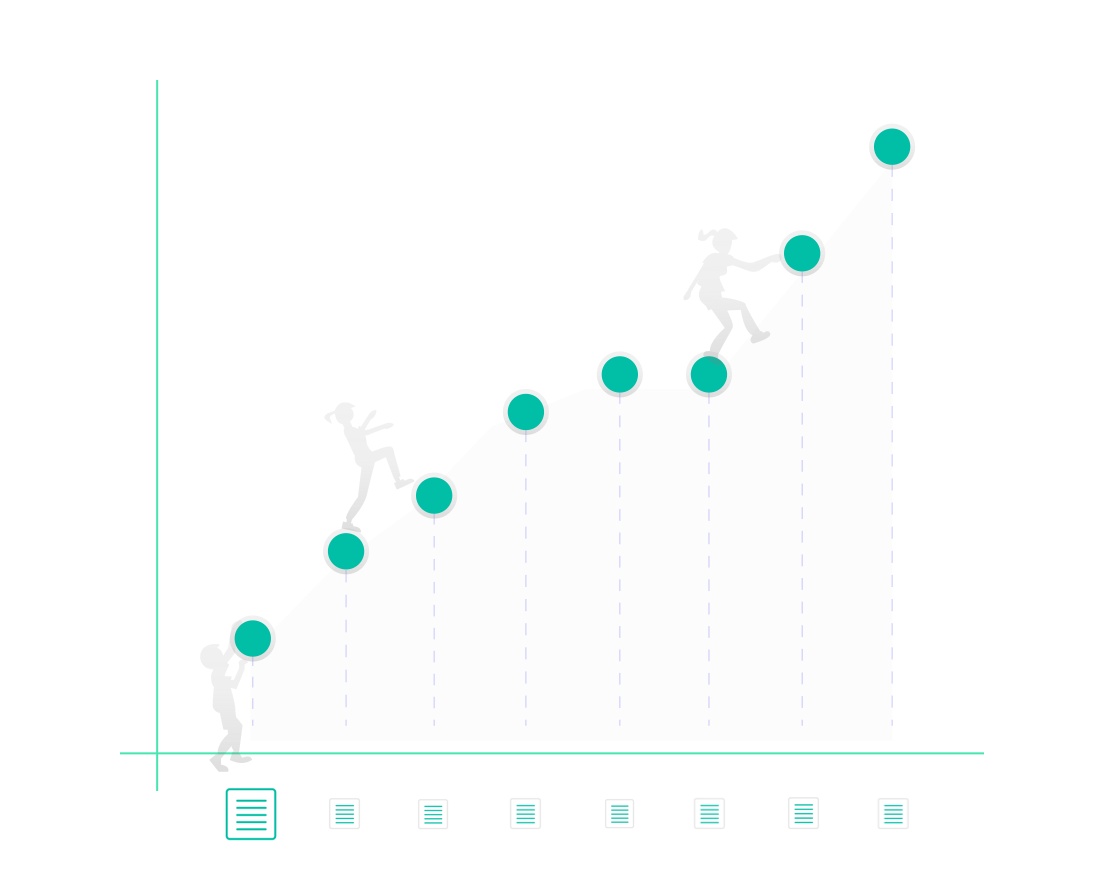

**FTRL** is an online learning algorithm used for binary classification tasks. It became popular in the advertisement domain showing great results in CTR (Click Through Rate: Predicting if a user will click on an ad) problems with its incremental learning strategy.

Read more about FTRL: https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/41159.pdf

This notebook provides a **baseline FTRL model** using datatable. Datatable reads the entire dataset very fast as shown [here](https://www.kaggle.com/rohanrao/riiid-with-blazing-fast-rid). It has the **FTRL model inbuilt** which runs extremely fast as well, so it is convenient to use them together.


In [ ]:
# installing datatable
!pip install ../input/python-datatable/datatable-0.11.0-cp37-cp37m-manylinux2010_x86_64.whl

In [ ]:
## importing packages
import datatable as dt
import pandas as pd

from datatable.models import Ftrl
from sklearn.metrics import roc_auc_score

import riiideducation

## Loading data
Using the .jay format of the training data is the best option for datatable. It is available as a **Kaggle Dataset** [here](https://www.kaggle.com/rohanrao/riiid-train-data-multiple-formats).


In [ ]:
## reading data
train = dt.fread("../input/riiid-train-data-multiple-formats/riiid_train.jay")
questions = dt.fread("../input/riiid-test-answer-prediction/questions.csv")

In [ ]:
## viewing train data
train

In [ ]:
## viewing questions data
questions

## Data Preparation
For this baseline notebook only **6 features** are used. Exploring and creating more features will certainly improve the score.

The first **90M** rows are used for training and rest for validation as a convenient choice though this might not be the most optimal validation strategy.


In [ ]:
## merging questions metadata with train data
questions.key = "question_id"
train.names = {"content_id": "question_id"}

train = train[dt.f.content_type_id == 0, :]
train = train[:, :, dt.join(questions)]

In [ ]:
## preparing train and validation data
train_features = ["user_id", "question_id", "prior_question_elapsed_time"]
question_features = ["bundle_id", "part", "tags"]

target = train[:, "answered_correctly"]
train = train[:, train_features + question_features]

X_train, X_valid = train[:90000000, :], train[90000000:, :]
y_train, y_valid = target[:90000000, :], target[90000000:, :]

## FTRL Model
Datatable can be directly used to build an FTRL model. Documentation: https://datatable.readthedocs.io/en/latest/manual/ftrl.html

For this baseline notebook, all the default hyper-parameters are used. Tuning the hyper-parameters can improve the model's performance. Training the model on the entire dataset takes less than 20 seconds!

In [ ]:
## building and validating FTRL model
model_ftrl = Ftrl() # you can set hyper-parameters with: model_ftrl = Ftrl(alpha = 0.005, nepochs = 1)

model_ftrl.fit(X_train, y_train, X_validation=X_valid, y_validation=y_valid)
y_pred = model_ftrl.predict(X_valid)
    
print(f"Validation AUC: {roc_auc_score(y_valid.to_numpy(), y_pred.to_numpy())}")

In [ ]:
## rebuilding FTRL model on entire dataset
model_ftrl = Ftrl()

model_ftrl.fit(train, target)

## Inferencing and Incremental Learning
One of the great advantages of FTRL is the ability to perform **incremental learning**. What this really means is for every batch of newly available training data the model weights can be fine-tuned.

Since this is precisely how the test data will be made available from the API, we could easily perform inferencing and then incremental learning of each batch of new data that becomes available.

In [ ]:
## initializing test environment
env = riiideducation.make_env()
iter_test = env.iter_test()

In [ ]:
## inferencing and incremental learning
prev_test = pd.DataFrame()

for (current_test, current_prediction_df) in iter_test:

    # extracting previous batch's targets
    prev_target = eval(current_test["prior_group_answers_correct"].iloc[0])

    # incremental learning of FTRL model
    if prev_test.shape[0] > 0:
        prev_test["target"] = prev_target
        X_prev_test = dt.Frame(prev_test[prev_test.content_type_id == 0].rename(columns = {"content_id": "question_id"})[train_features + ["target"]])
        X_prev_test = X_prev_test[:, :, dt.join(questions)]

        y_prev_test = X_prev_test[:, "target"]
        X_prev_test = X_prev_test[:, train_features + question_features]

        model_ftrl.fit(X_prev_test, y_prev_test)

    # inferencing of current batch
    X_test = dt.Frame(current_test[current_test.content_type_id == 0].rename(columns = {"content_id": "question_id"})[train_features])
    X_test = X_test[:, :, dt.join(questions)]
    X_test = X_test[:, train_features + question_features]
    current_prediction_df.answered_correctly = model_ftrl.predict(X_test).to_numpy().ravel()
    env.predict(current_prediction_df)

    # retaining current batch data for next batch
    prev_test = current_test.copy(deep = True)


## Scope of improvement
While the notebook provides a baseline workflow for building an **incremental FTRL model**, there is a lot of scope for improving it. Here are some ideas (and there can be more) worth exploring:

* Choose a good validation dataset that leads to stability
* Create more features that can work well with FTRL
* Tune [hyper-parameters of FTRL](https://datatable.readthedocs.io/en/latest/manual/ftrl.html#ftrl-model-parameters)
* Blend multiple FTRL models or ensemble with models of other types